In [33]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from diffusers import UNet2DConditionModel, UNet2DModel,DDPMScheduler
from diffusers.optimization import get_cosine_schedule_with_warmup
from transformers import CLIPTextModel, CLIPTokenizer

In [34]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

In [35]:
# 初始化模型

model = UNet2DModel(
    sample_size=256,            # 输入图像的大小
    in_channels=2,              # 输入通道数（噪声图像1 + mask1）
    out_channels=1,             # 输出通道数
    layers_per_block=2,
    block_out_channels=(64, 128, 256, 512),  # 每层的通道数
    down_block_types=("DownBlock2D", "AttnDownBlock2D", "DownBlock2D", "DownBlock2D"),
    up_block_types=("UpBlock2D", "AttnUpBlock2D", "UpBlock2D", "UpBlock2D")
)
# 条件处理器
scheduler = DDPMScheduler(num_train_timesteps=1000)

In [36]:
# 优化器和学习率调度器
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=500,
    num_training_steps=10000,  # 假设总训练步骤为 10,000
)
# 定义损失函数
loss_fn = nn.MSELoss()

In [43]:
#load data
from loaddata_processed import create_dataloader

root_directory = "/data/fupeiguo/MRI images/processed/"  # 替换为实际的根目录路径
# dataloader = load_nii_data(root_directory, batch_size=1, shuffle=True, num_workers=0)
dataloader = create_dataloader(root_directory, batch_size=16, shuffle=True, num_workers=0)
for batch_idx, (images, labels) in enumerate(dataloader):
    print(f"Batch {batch_idx + 1}")
    print(f"Image shape: {images.shape}")  # 批次的图像形状
    print(f"Label shape: {labels.shape}")  # 批次的标签形状
    print(labels.max(), labels.min())
    break

Batch 1
Image shape: torch.Size([16, 256, 256])
Label shape: torch.Size([16, 256, 256])
tensor(15.) tensor(0.)


In [59]:
# 训练过程
def train(model, scheduler, dataloader, num_epochs, device):
    model.train()
    model.to(device)
    for epoch in range(num_epochs):
        for batch_idx, (images, labels) in enumerate(dataloader):
            # 准备数据
            images = images.to(device).unsqueeze(1)
            labels = labels.to(device).unsqueeze(1)

            # 添加噪声到图像
            timesteps = torch.randint(0, scheduler.num_train_timesteps, (images.size(0),), device=device).long()
            noise = torch.randn_like(images)  # 生成与图像相同形状的随机噪声
            noisy_images = scheduler.add_noise(images, noise, timesteps)
            input_with_mask = torch.cat([noisy_images, labels.float()], dim=1) 

            # 前向传播
            output = model(input_with_mask, timesteps)
            model_output = output.sample

            # 计算损失
            loss = loss_fn(model_output, noise)

            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            lr_scheduler.step()

            # 日志
            if batch_idx % 10 == 0:
                print(f"Epoch {epoch + 1}/{num_epochs}, Batch {batch_idx + 1}/{len(dataloader)}, Loss: {loss.item()}")
        # 保存模型在每个 epoch 末尾
        if epoch % 10 == 0:
            torch.save(model.state_dict(), f"model_epoch_{epoch + 1}.pth")
            print(f"Model saved at epoch {epoch + 1} as 'model_epoch_{epoch + 1}.pth'.")

    # 绘制并保存损失图
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label="Training Loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.legend()
    plt.grid(True)
    plt.savefig("training_loss.png")
    print("Training loss curve saved as 'training_loss.png'.")
    plt.show()

In [60]:
# 启动训练
train(model, scheduler, dataloader, num_epochs=100, device=device)

Epoch 1/500, Batch 1/187, Loss: 0.005377177149057388
Epoch 1/500, Batch 11/187, Loss: 0.002885547000914812
Epoch 1/500, Batch 21/187, Loss: 0.010890781879425049
Epoch 1/500, Batch 31/187, Loss: 0.009180758148431778
Epoch 1/500, Batch 41/187, Loss: 0.012314723804593086
Epoch 1/500, Batch 51/187, Loss: 0.0021204515360295773
Epoch 1/500, Batch 61/187, Loss: 0.004849096294492483
Epoch 1/500, Batch 71/187, Loss: 0.007423192262649536
Epoch 1/500, Batch 81/187, Loss: 0.0016179523663595319
Epoch 1/500, Batch 91/187, Loss: 0.013163362629711628
Epoch 1/500, Batch 101/187, Loss: 0.005871132016181946
Epoch 1/500, Batch 111/187, Loss: 0.010390258394181728
Epoch 1/500, Batch 121/187, Loss: 0.01991332322359085
Epoch 1/500, Batch 131/187, Loss: 0.0044605727307498455
Epoch 1/500, Batch 141/187, Loss: 0.01471130270510912
Epoch 1/500, Batch 151/187, Loss: 0.013625930063426495
Epoch 1/500, Batch 161/187, Loss: 0.007365835830569267
Epoch 1/500, Batch 171/187, Loss: 0.002578121144324541
Epoch 1/500, Batch 1

KeyboardInterrupt: 

/tmp/ipykernel_2689626/3312161430.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model_epoch_111.pth"))


Model loaded from 'trained_model.pth'.
1000
Test results saved as 'test_results.png'.


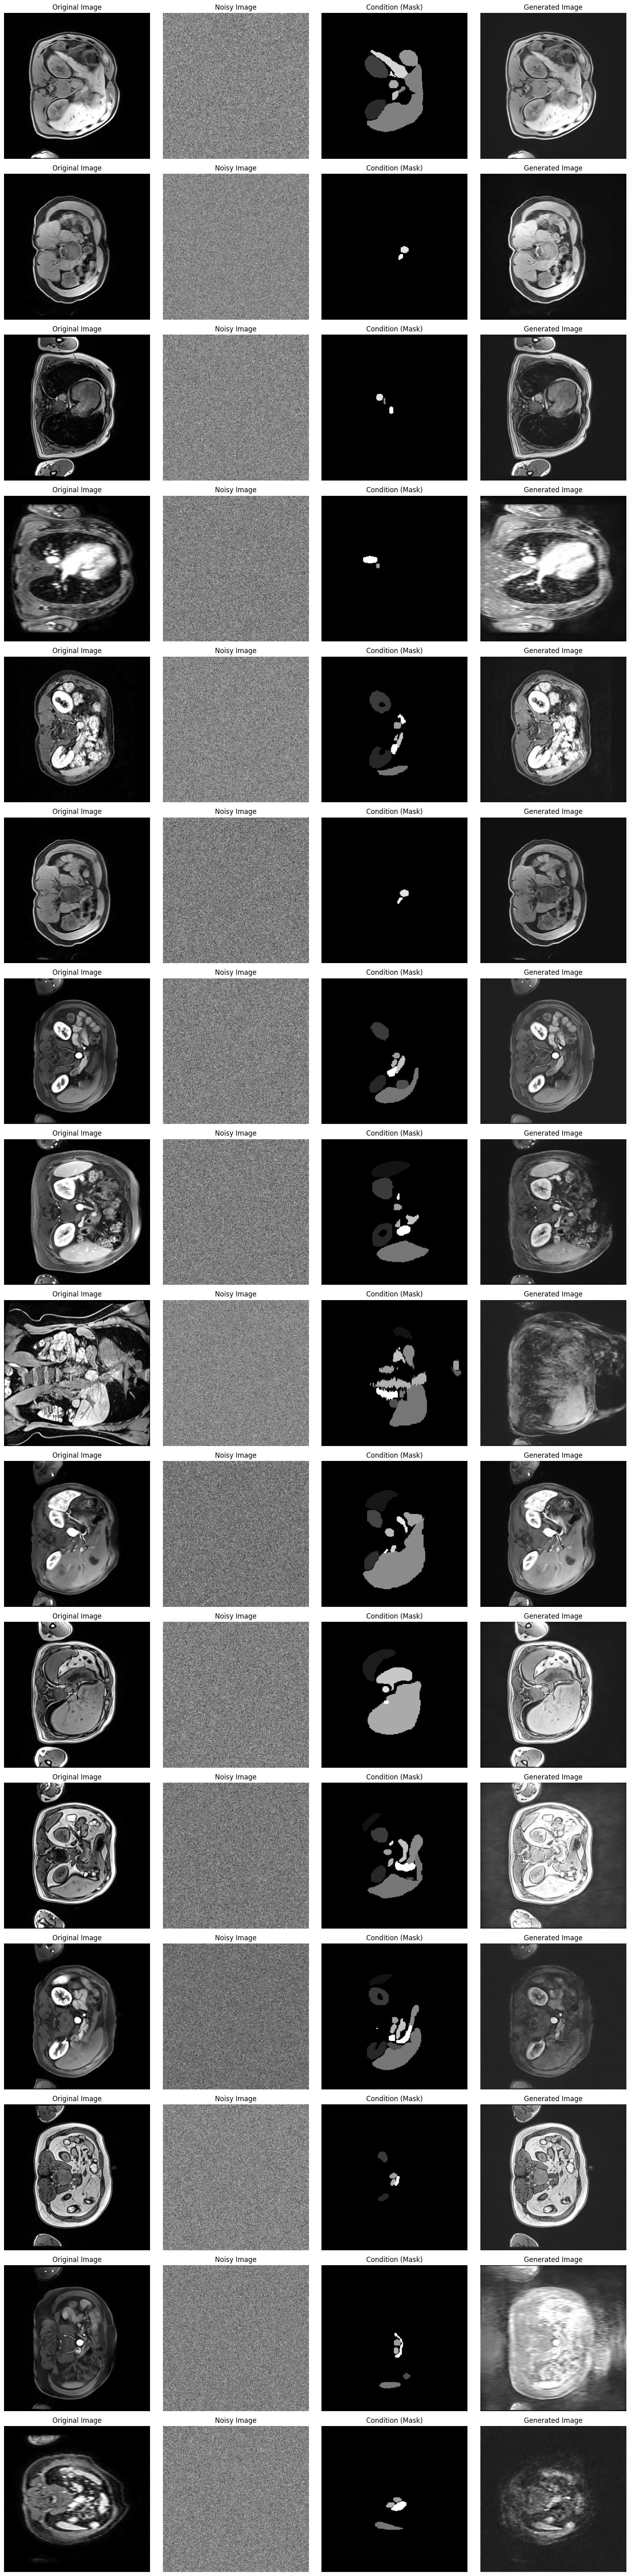

In [62]:
import torch
import matplotlib.pyplot as plt

# 测试函数
def test(model, scheduler, test_dataloader, device):
    model.eval()
    model.to(device)

    # 加载保存的模型
    model.load_state_dict(torch.load("model_epoch_111.pth"))
    print("Model loaded from 'trained_model.pth'.")

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_dataloader):
            # 准备数据
            images = images.to(device).unsqueeze(1)  # 原始图像
            labels = labels.to(device).unsqueeze(1)  # 条件
    
            # 随机生成初始噪声图像
            noisy_images = torch.randn_like(images)  # 随机噪声，形状与 images 一致
            scheduler.alphas_cumprod = scheduler.alphas_cumprod.to(device)
            scheduler.one = scheduler.one.to(device)
            if hasattr(scheduler, "betas"):
                scheduler.betas = scheduler.betas.to(device)
            if hasattr(scheduler, "sigmas"):
                scheduler.sigmas = scheduler.sigmas.to(device)
            # 反向扩散过程
            generated_images = noisy_images.clone()
            print(scheduler.num_train_timesteps)
            for t in reversed(range(scheduler.num_train_timesteps)):
                timesteps = torch.tensor([t], device=device)  # 当前时间步
                input_with_mask = torch.cat([generated_images, labels.float()], dim=1)  # 拼接条件
                output = model(input_with_mask, timesteps)  # 前向传播
                generated_images = scheduler.step(output.sample, timesteps, generated_images).prev_sample
    
            # 显示并保存结果
            plot_results(images, noisy_images, generated_images, labels)
            break  # 只显示第一个 batch 的结果


# 绘制结果对比
def plot_results(original, noisy, generated, condition):
    original = original.squeeze().cpu().numpy()
    noisy = noisy.squeeze().cpu().numpy()
    generated = generated.squeeze().cpu().numpy()
    condition = condition.squeeze().cpu().numpy()

    batch_size = original.shape[0]
    fig, axes = plt.subplots(batch_size, 4, figsize=(16, 4 * batch_size))

    for i in range(batch_size):
        axes[i, 0].imshow(original[i], cmap="gray")
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(noisy[i], cmap="gray")
        axes[i, 1].set_title("Noisy Image")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(condition[i], cmap="gray")
        axes[i, 2].set_title("Condition (Mask)")
        axes[i, 2].axis("off")

        axes[i, 3].imshow(generated[i], cmap="gray")
        axes[i, 3].set_title("Generated Image")
        axes[i, 3].axis("off")

    plt.tight_layout()
    plt.savefig("test_results.png")
    print("Test results saved as 'test_results.png'.")
    plt.show()

# 调用测试函数
test(model, scheduler, dataloader, device=device)
